In [1]:
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import pandas as pd
from functools import partial

from counterfactual_package.data.datasets import download_dataset, PandasDataset
from counterfactual_package.data.data_preprocess import valid_data_split, infer_column_types
from counterfactual_package.data.transformer import CtganTransformer, simple_transform, reverse_simple_transform
from counterfactual_package.engines.training import train_classifier, train_ctgan
from counterfactual_package.engines.ctgan_synthesizer import CtganSynthesizer
from counterfactual_package.utils.utils import load_json_file, get_checkpoint, get_model, write_json_file
from counterfactual_package.models.classifiers import Classifier

output_dir = Path("./experiments")
data_dir = Path("./data")

dataset_names = ["adult", 
                 "heart_disease", 
                 "diabetes",
                 "employees"]

config = load_json_file(output_dir / "config.json")


# Load notifier extension
import sys

notify_dir = "/Users/stighellemans/Desktop/Programming/Python/notifier"
if notify_dir not in sys.path:
    sys.path.append(notify_dir)
# Load the extension
%load_ext notify

### Download and Prepare Datasets

In [6]:
for dataset_name in dataset_names:
    df = download_dataset(data_dir, dataset_name)

    # Split the data into training, validation, and test sets
    categorical_cols = infer_column_types(df)[0]
    split = valid_data_split(df, categorical_cols)

    train, val, test = split["train"], split["val"], split["test"]

    # Save the data
    train.to_csv(data_dir / dataset_name / f"{dataset_name}_train.csv", index=False)
    val.to_csv(data_dir / dataset_name / f"{dataset_name}_val.csv", index=False)
    test.to_csv(data_dir / dataset_name / f"{dataset_name}_test.csv", index=False)


Dataset URL: https://www.kaggle.com/datasets/uciml/adult-census-income
Dataset URL: https://www.kaggle.com/datasets/alphiree/cardiovascular-diseases-risk-prediction-dataset
Dataset URL: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset
Dataset URL: https://www.kaggle.com/datasets/stealthtechnologies/employee-attrition-dataset


### Train ground-truth data transformers

In [8]:
## Train the transformers ##
for dataset_name in dataset_names:
    train = pd.read_csv(data_dir / dataset_name / f"{dataset_name}_train.csv")
    transformer = CtganTransformer()
    transformer.fit(train)
    output_path = output_dir / dataset_name / "data_transformer"
    output_path.mkdir(parents=True, exist_ok=True)
    torch.save(transformer.state_dict(), output_path / "ground_truth_transformer.pth")

### Training Classifier

In [ ]:


for dataset_name in dataset_names:
    print(f"Training classifiers for {dataset_name}")
    
    classifier_config = config[dataset_name]["classifier"]
    output_path = output_dir / dataset_name / "classifier"

    # Load the data transformer
    ground_truth_transformer = CtganTransformer()
    ground_truth_transformer.load_state_dict(torch.load(output_path / "ground_truth_transformer.pth"))
    simple_transform_fn = partial(simple_transform, metadata=ground_truth_transformer.metadata)

    # Load the data
    train = pd.read_csv(data_dir / dataset_name / f"{dataset_name}_train.csv")
    val = pd.read_csv(data_dir / dataset_name / f"{dataset_name}_val.csv")

    ### Simple transform classifier ###
    train_classifier(train, val, classifier_config, output_path / "simple_transform_classifier", 
                     ground_truth_transformer.metadata, simple_transform_fn, 
                     only_best=True, resume=False, saving_each_x_epoch=1)
    ### Classifier of same data representation as FCEGAN ###
    train_classifier(train, val, classifier_config, output_path / "ctgan_transform_classifier", 
                     ground_truth_transformer.metadata, ground_truth_transformer.transform, 
                     only_best=True, resume=False, saving_each_x_epoch=1)

adult
Training started with configuration:
{'batch_size': 300,
 'dropout': 0,
 'epochs': 10,
 'hidden_dimensions': [512, 512],
 'input_dim': 103,
 'loss': 'weighted',
 'lr': 0.001,
 'output_dim': 2,
 'target_name': 'Target',
 'weight_decay': 0}
Epoch 1/10, Train Loss: 0.4159, Test Loss: 0.4231, Test Accuracy: 0.7561
Epoch 2/10, Train Loss: 0.3690, Test Loss: 0.4080, Test Accuracy: 0.7795
Epoch 3/10, Train Loss: 0.3614, Test Loss: 0.4060, Test Accuracy: 0.7793
Epoch 4/10, Train Loss: 0.3558, Test Loss: 0.4031, Test Accuracy: 0.7848
Epoch 5/10, Train Loss: 0.3502, Test Loss: 0.4014, Test Accuracy: 0.7905
Epoch 6/10, Train Loss: 0.3439, Test Loss: 0.4037, Test Accuracy: 0.7939
Epoch 7/10, Train Loss: 0.3367, Test Loss: 0.4092, Test Accuracy: 0.7953
Epoch 8/10, Train Loss: 0.3288, Test Loss: 0.4180, Test Accuracy: 0.7958
Epoch 9/10, Train Loss: 0.3199, Test Loss: 0.4297, Test Accuracy: 0.7941
Epoch 10/10, Train Loss: 0.3107, Test Loss: 0.4424, Test Accuracy: 0.7924
Training started with co

In [16]:
from sklearn.metrics import confusion_matrix
import numpy as np

### confusion matrix classifiers ###
# Function to get predictions
def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    return all_preds, all_labels

transform_name = "simple"

confusion_matrices = {}
for dataset_name in dataset_names:
    print(f"Making predicted datasets for {dataset_name}")
    output_path = output_dir / dataset_name
    target_name = config[dataset_name]["target_name"]

    classifier_config = load_json_file(get_model(output_dir / dataset_name, "classifier", 
                                            transform_name, "config.json")
                                )
    
    classifier = Classifier(**classifier_config)
    classifier.load_state_dict(get_checkpoint(get_model(
                                                    output_path, 
                                                    f"{transform_name}_transform_classifier", 
                                                    ".pth")
                                                )["model_state_dict"]
                                )

    ground_truth_transformer = CtganTransformer()
    ground_truth_transformer.load_state_dict(torch.load(output_path / "data_transformer" / "ground_truth_transformer.pth"))

    if transform_name == "simple":
        transform = partial(simple_transform, metadata=ground_truth_transformer.metadata)
    else:
        transform = ground_truth_transformer.transform

    # Get the prediction labels
    target_label_annotations = list(ground_truth_transformer.metadata[target_name].value_frequencies)


    data = pd.read_csv(data_dir / dataset_name / f"{dataset_name}_test.csv")
    data_set = PandasDataset(data, target_name, transform)
    data_loader = DataLoader(data_set, batch_size=1000)

    preds, labels = get_predictions(classifier, data_loader)
    confusion_matrix_instance = confusion_matrix(labels, preds)

    # Calculate accuracy
    accuracy = np.trace(confusion_matrix_instance) / np.sum(confusion_matrix_instance)  # Sum of diagonal / total sum
    print(f"Accuracy: {accuracy:.2f}")

    # Calculate the percentage confusion matrix
    confusion_matrix_percentage = confusion_matrix_instance.astype('float') / confusion_matrix_instance.sum(axis=1)[:, np.newaxis] * 100
    print("Percentage Confusion Matrix:")
    print(confusion_matrix_percentage)

    # Additional metrics for multi-class (optional per-class analysis)
    # True Positives (TP), False Positives (FP), False Negatives (FN), True Negatives (TN) per class
    TP = np.diag(confusion_matrix_instance)
    FP = confusion_matrix_instance.sum(axis=0) - TP
    FN = confusion_matrix_instance.sum(axis=1) - TP
    TN = confusion_matrix_instance.sum() - (FP + FN + TP)

    # Print confusion matrices
    print("Confusion Matrix for:", dataset_name, transform_name)
    print(confusion_matrix_instance)

    confusion_matrices[dataset_name] = {
        "type": transform_name,
        "dataset": dataset_name,
        "absolute": confusion_matrix_instance,
        "percentage": confusion_matrix_percentage,
        "accuracy": accuracy,
        "target_labels": target_label_annotations,
    }

Making predicted datasets for adult
Accuracy: 0.81
Percentage Confusion Matrix:
[[78.78922769 21.21077231]
 [12.46753247 87.53246753]]
Confusion Matrix for: adult simple
[[3540  953]
 [ 192 1348]]
Making predicted datasets for heart_disease
Accuracy: 0.87
Percentage Confusion Matrix:
[[92.48148083  7.51851917]
 [74.05832321 25.94167679]]
Confusion Matrix for: heart_disease simple
[[52560  4273]
 [ 3657  1281]]
Making predicted datasets for diabetes
Accuracy: 0.75
Percentage Confusion Matrix:
[[81.67650919 15.88160855  2.44188226]
 [55.05964912 41.51578947  3.4245614 ]
 [63.47177849 33.75931842  2.76890309]]
Confusion Matrix for: diabetes simple
[[34853  6777  1042]
 [ 3923  2958   244]
 [  596   317    26]]
Making predicted datasets for employees
Accuracy: 0.75
Percentage Confusion Matrix:
[[76.32999229 23.67000771]
 [25.56898005 74.43101995]]
Confusion Matrix for: employees simple
[[5940 1842]
 [1820 5298]]


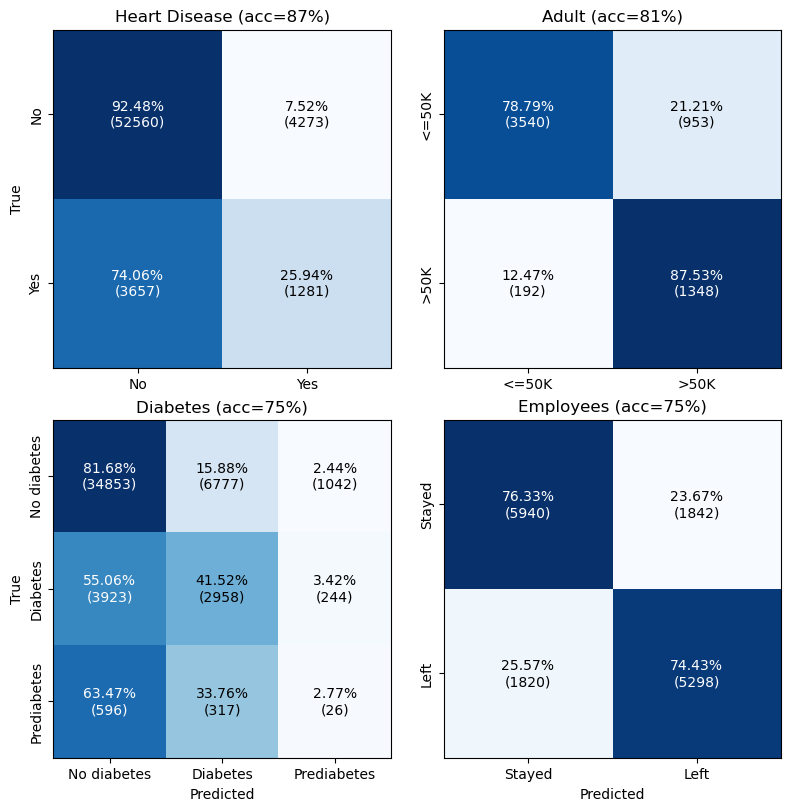

In [35]:
from matplotlib import pyplot as plt

label_names = {
    "adult": {
        "dataset": "Adult",
    },
    "heart_disease": {
        "dataset": "Heart Disease",
    },
    "diabetes": {
        "dataset": "Diabetes",
    },
    "employees": {
        "dataset": "Employees",
    }
}

mosaic = [
    ["Heart Disease", "Adult"],
    ["Diabetes", "Employees"] 
]

# Function to dynamically plot heatmaps
def plot_confusion_matrix(ax, cm_instance, dataset_name, accuracy, target_labels, show_x_label=False, show_y_label=False):
    cax = ax.matshow(cm_instance["percentage"], cmap='Blues')
    # Create annotations with percentages and absolute values
    labels = [
        f'{perc:.2f}%\n({val})'
        for perc, val in zip(cm_instance["percentage"].flatten(), cm_instance["absolute"].flatten())
    ]
    labels = np.asarray(labels).reshape(cm_instance["percentage"].shape)
    for (i, j), _ in np.ndenumerate(cm_instance["percentage"]):
        ax.text(j, i, labels[i, j], ha='center', va='center',
                color=get_text_color(cm_instance["percentage"][i, j]))

    # Set labels and titles
    ax.set_xticks(np.arange(len(target_labels)))
    ax.set_xticklabels(target_labels)
    ax.set_yticks(np.arange(len(target_labels)))
    ax.set_yticklabels(target_labels, rotation=90, va='center')
    ax.xaxis.set_ticks_position('bottom')
    if show_x_label:
        ax.set_xlabel('Predicted')
    if show_y_label:
        ax.set_ylabel('True')
    ax.set_title(f'{dataset_name} (acc={round(accuracy * 100)}%)')
    return cax

# Function to determine text color
def get_text_color(value, threshold=50):
    return 'white' if value > threshold else 'black'

# Dynamically generate layout and plot
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8, 8), layout='constrained')

# Iterate through datasets
for dataset, details in confusion_matrices.items():
    dataset_name = label_names[dataset]["dataset"]
    cm_instance = details
    ax = axs[dataset_name]
    show_x_label = dataset_name in ["Diabetes", "Employees"]
    show_y_label = dataset_name in ["Heart Disease", "Diabetes"]
    cax = plot_confusion_matrix(
        ax, cm_instance, dataset_name, cm_instance["accuracy"], cm_instance["target_labels"], show_x_label, show_y_label
    )

# Set overall title and save figure
plt.savefig("figures/classifier_confusion_matrices.png", dpi=100)
plt.show()

### Making predicted datasets

In [12]:
for dataset_name in dataset_names:
    print(f"Making predicted datasets for {dataset_name}")
    output_path = output_dir / dataset_name
    target_name = config[dataset_name]["target_name"]
    new_target_name = f"{target_name}_pred"

    for transform_name in ["simple", "ctgan"]:
        classifier_config = load_json_file(get_model(output_dir / dataset_name, "classifier", 
                                               transform_name, "config.json")
                                    )
        
        classifier = Classifier(**classifier_config)
        classifier.load_state_dict(get_checkpoint(get_model(
                                                        output_path, 
                                                        f"{transform_name}_transform_classifier", 
                                                        ".pth")
                                                  )["model_state_dict"]
                                    )

        ground_truth_transformer = CtganTransformer()
        ground_truth_transformer.load_state_dict(torch.load(output_path / "ground_truth_transformer.pth"))

        if transform_name == "simple":
            transform = partial(simple_transform, metadata=ground_truth_transformer.metadata)
        else:
            transform = ground_truth_transformer.transform

        for split in ["train", "val", "test"]:
            data = pd.read_csv(data_dir / dataset_name / f"{dataset_name}_{split}.csv")
            data_set = PandasDataset(data, target_name, transform)
            data_loader = DataLoader(data_set, batch_size=1000)

            target_names = {i: v for i, v in enumerate(ground_truth_transformer.metadata[target_name].value_frequencies)}

            preds = []
            for x, _ in data_loader:
                preds.append(torch.argmax(classifier(x), dim=1))

            preds = pd.Series(torch.cat(preds, dim=0).numpy())
            new_data = data.copy().drop(columns=[target_name])
            new_data[new_target_name] = preds.apply(lambda x: target_names[x])

            new_data.to_csv(data_dir / dataset_name / f"{dataset_name}_{split}_{transform_name}_predicted.csv", index=False)

Making predicted datasets for adult
Making predicted datasets for heart_disease
Making predicted datasets for diabetes
Making predicted datasets for employees


### Train prediction data transformers

In [3]:
for dataset_name in dataset_names:
    print("Training prediction data transformers for", dataset_name)
    for transform_name in ["simple", "ctgan"]:
        train = pd.read_csv(data_dir / dataset_name / f"{dataset_name}_train_{transform_name}_predicted.csv")
        transformer = CtganTransformer()
        transformer.fit(train)
        output_path = output_dir / dataset_name / "data_transformer"
        output_path.mkdir(parents=True, exist_ok=True)
        torch.save(transformer.state_dict(), output_path / f"{transform_name}_prediction_transformer.pth")

### Training two CTGANs as fakeness measures:
(1) 'train_ctgan' to use in training

(2) 'eval_ctgan' to use for evaluation

In [5]:
for dataset_name in dataset_names:
    ctgan_config = config[dataset_name]["ctgan"]
    print(f"Training CTGANs for {dataset_name}")
    for transform_name in ["simple", "ctgan"]:
        output_path = output_dir / dataset_name
        train = pd.read_csv(data_dir / dataset_name / f"{dataset_name}_train_{transform_name}_predicted.csv")
        ctgan_config = config[dataset_name]["ctgan"]

        data_transformer = CtganTransformer()
        data_transformer.load_state_dict(torch.load(output_path / "data_transformer" 
                                                    / f"{transform_name}_prediction_transformer.pth"))

        for ctgan_type in ["train", "eval"]:
            if ctgan_type == "train" and transform_name == "simple":
                save_path = output_path / "ctgan" / f"{transform_name}_prediction_{ctgan_type}_simple_ctgan.pth"
                save_path.parent.mkdir(parents=True, exist_ok=True)
                ctgan_config["epochs"] = 300
                train_ctgan(train, data_transformer, **ctgan_config, simple_transform=True, save_path=save_path)

            # save_path = output_path / "ctgan" / f"{transform_name}_prediction_{ctgan_type}_ctgan.pth"
            # save_path.parent.mkdir(parents=True, exist_ok=True)
            # train_ctgan(train, data_transformer, **ctgan_config, save_path=save_path)

Training CTGANs for adult


100%|██████████| 300/300 [16:46<00:00,  3.36s/it]


Training CTGANs for heart_disease


100%|██████████| 300/300 [56:34<00:00, 11.32s/it]


Training CTGANs for diabetes


100%|██████████| 300/300 [51:30<00:00, 10.30s/it]


Training CTGANs for employees


100%|██████████| 300/300 [29:14<00:00,  5.85s/it]


### Calculating fakeness measures of real counterfactuals

In [7]:
real_fakeness = {}
for dataset_name in dataset_names:
    real_fakeness[dataset_name] = {}
    for transform_name in ["simple", "ctgan"]:
        # Load test data
        test = pd.read_csv(data_dir / dataset_name / f"{dataset_name}_test_{transform_name}_predicted.csv")

        # Make subsets to sample counterfactuals from
        target_name = config[dataset_name]["target_name"] + "_pred"
        real_counterfactual_pool = {value: test[test[target_name] != value] for value in test[target_name].unique()}

        def get_counterfactual(target_value):
            return real_counterfactual_pool[target_value].sample(1).iloc[0]

        # Load eval CTGAN
        eval_ctgan = CtganSynthesizer()
        eval_ctgan.load_state_dict(
            torch.load(
            get_model(
                output_dir / dataset_name,
                f"{transform_name}_prediction_eval_ctgan",
                ".pth",
            )
            )
        )

        # Sample real counterfactuals
        counterfactuals = test.apply(lambda x: get_counterfactual(x[target_name]), axis=1)

        # Make conditional vectors
        col_id = eval_ctgan.metadata.column_to_idx(target_name, only_categories=True)
        cond_vector_dim = eval_ctgan.sampler.dim_conditional_vector()
        cond_vector_start = eval_ctgan.sampler.categorical_column_cond_start_id[col_id]
        value_ids = torch.argmax(
            eval_ctgan.transformer.transform(counterfactuals[target_name]), dim=1
        )
        cond_vecs = torch.zeros((len(value_ids), cond_vector_dim))
        cond_vecs[torch.arange(len(value_ids)), cond_vector_start + value_ids] = 1.0

        counterfactuals = eval_ctgan.transformer.transform(counterfactuals)
        discriminator_input = torch.cat([counterfactuals, cond_vecs], dim=1)
        
        # Discriminator works per pacs
        discriminator_input_repeated = discriminator_input.repeat_interleave(
            eval_ctgan.config["pac"], dim=0
        )
        with torch.no_grad():
            fakeness = eval_ctgan.model.discriminator(discriminator_input_repeated).squeeze()

        real_fakeness[dataset_name][transform_name] = fakeness.mean().item()

write_json_file(output_dir / "real_fakeness.json", real_fakeness)

adult simple 0.8291922211647034
adult ctgan 0.5206748843193054
heart_disease simple 1.550836205482483
heart_disease ctgan 1.873957633972168
diabetes simple 2.172031879425049
diabetes ctgan 1.7475354671478271
employees simple 4.722607135772705
employees ctgan 4.550609588623047
